In [9]:
from train_util_escnn import *
from IPython.display import clear_output
import torch
import time

device = "cuda:1" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 40

LEARNING_RATE = 1e-4

EPOCHS = 600

# ignore the warnings, they are for tensorboard.

working with model: 19
Train Loss EPOCH      1: 1.3918e+00 | Valid Loss EPOCH      1: 1.3840e+00 | Test Loss EPOCH      1: 1.3755e+00 | time:  0.9596
Train Loss EPOCH     11: 2.0393e-01 | Valid Loss EPOCH     11: 1.8783e-01 | Test Loss EPOCH     11: 1.7957e-01 | time:  0.9264
Train Loss EPOCH     21: 9.8643e-02 | Valid Loss EPOCH     21: 1.0079e-01 | Test Loss EPOCH     21: 8.8276e-02 | time:  0.9548
Train Loss EPOCH     31: 6.8596e-02 | Valid Loss EPOCH     31: 7.1746e-02 | Test Loss EPOCH     31: 6.6477e-02 | time:  0.9931
Train Loss EPOCH     41: 5.6385e-02 | Valid Loss EPOCH     41: 6.0032e-02 | Test Loss EPOCH     41: 5.4302e-02 | time:  0.9826
Train Loss EPOCH     51: 5.0009e-02 | Valid Loss EPOCH     51: 5.4115e-02 | Test Loss EPOCH     51: 4.9028e-02 | time:  0.9794
Train Loss EPOCH     61: 4.5123e-02 | Valid Loss EPOCH     61: 4.9711e-02 | Test Loss EPOCH     61: 4.4778e-02 | time:  0.9634
Train Loss EPOCH     71: 4.1158e-02 | Valid Loss EPOCH     71: 4.6188e-02 | Test Loss EP

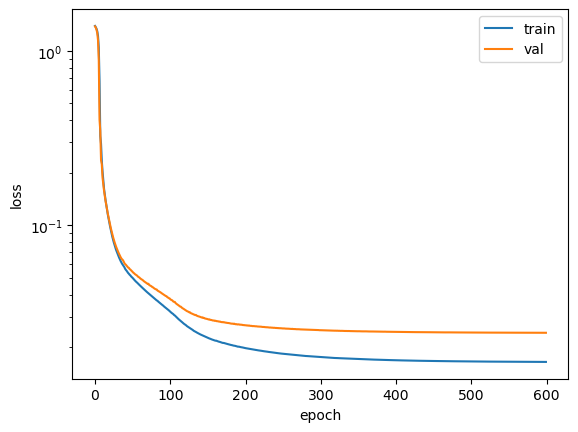

data output done!
working with model: 20
Train Loss EPOCH      1: 1.7365e+00 | Valid Loss EPOCH      1: 1.6896e+00 | Test Loss EPOCH      1: 1.6763e+00 | time:  0.9887
Train Loss EPOCH     11: 6.0401e-02 | Valid Loss EPOCH     11: 6.4651e-02 | Test Loss EPOCH     11: 5.6448e-02 | time:  0.9959
Train Loss EPOCH     21: 3.3484e-02 | Valid Loss EPOCH     21: 3.9061e-02 | Test Loss EPOCH     21: 3.4212e-02 | time:  1.0215
Train Loss EPOCH     31: 2.7963e-02 | Valid Loss EPOCH     31: 3.4232e-02 | Test Loss EPOCH     31: 2.9917e-02 | time:  1.0231
Train Loss EPOCH     41: 2.5265e-02 | Valid Loss EPOCH     41: 3.1917e-02 | Test Loss EPOCH     41: 2.8028e-02 | time:  1.0426
Train Loss EPOCH     51: 2.3546e-02 | Valid Loss EPOCH     51: 3.0504e-02 | Test Loss EPOCH     51: 2.6370e-02 | time:  0.9319
Train Loss EPOCH     61: 2.2347e-02 | Valid Loss EPOCH     61: 2.9451e-02 | Test Loss EPOCH     61: 2.4817e-02 | time:  0.9692
Train Loss EPOCH     71: 2.1379e-02 | Valid Loss EPOCH     71: 2.8679e

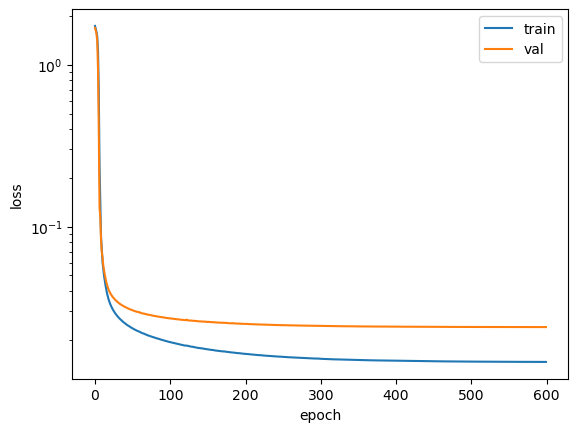

data output done!
working with model: 21
Train Loss EPOCH      1: 1.4929e+00 | Valid Loss EPOCH      1: 1.4906e+00 | Test Loss EPOCH      1: 1.4759e+00 | time:  1.0067
Train Loss EPOCH     11: 1.3463e-01 | Valid Loss EPOCH     11: 1.3001e-01 | Test Loss EPOCH     11: 1.1984e-01 | time:  1.0097
Train Loss EPOCH     21: 9.0473e-02 | Valid Loss EPOCH     21: 9.5292e-02 | Test Loss EPOCH     21: 8.5121e-02 | time:  1.0071
Train Loss EPOCH     31: 6.0974e-02 | Valid Loss EPOCH     31: 6.6195e-02 | Test Loss EPOCH     31: 5.7654e-02 | time:  1.0075
Train Loss EPOCH     41: 4.7557e-02 | Valid Loss EPOCH     41: 5.3490e-02 | Test Loss EPOCH     41: 4.6208e-02 | time:  1.0229
Train Loss EPOCH     51: 3.9196e-02 | Valid Loss EPOCH     51: 4.5770e-02 | Test Loss EPOCH     51: 3.9494e-02 | time:  1.0208
Train Loss EPOCH     61: 3.4640e-02 | Valid Loss EPOCH     61: 4.1956e-02 | Test Loss EPOCH     61: 3.5974e-02 | time:  1.0152
Train Loss EPOCH     71: 3.1877e-02 | Valid Loss EPOCH     71: 3.9322e

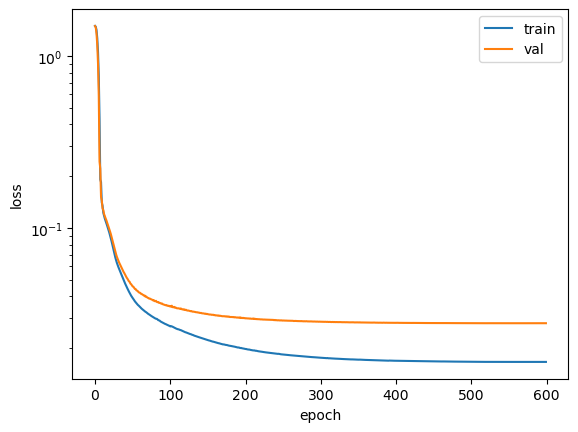

data output done!


In [13]:
for freq in range(2, 22):
    
    start_freq = 1
    len_freq = freq - start_freq + 1
    
    print('working with model: {}'.format(freq))
    
    MODEL_SAVE_PATH = './models/model_unet' + str(freq) + '.pth'

    xdata, ydata, test_xdata, test_ydata = get_data('out/'+str(freq-1), ['train/'+str(_freq) for _freq in range(start_freq, freq + 1)], 'data')

    train_dataset = MF_Dataset(xdata, ydata)
    test_dataset = MF_Dataset(test_xdata, test_ydata)

    generator = torch.Generator().manual_seed(42)

    train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

    train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    val_dataloader   = DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=True)

    test_dataloader  = DataLoader(dataset=test_dataset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)


    model = steerable_u_net(in_channels=1 + len_freq, feat=4).to(device)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    criterion = torch.nn.MSELoss()

    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = None

    for epoch in range(EPOCHS):
        tic = time.time()
        model.train()
        train_running_loss = 0
        for idx, xydata in enumerate((train_dataloader)):
            _xdata = xydata[0].float().to(device).squeeze()
            _ydata = xydata[1].float().to(device)

            y_pred = model(_xdata)
            optimizer.zero_grad()

            loss = criterion(y_pred, _ydata)
            train_running_loss += loss.item()

            loss.backward()
            optimizer.step()


        scheduler.step()

        train_loss = train_running_loss / (idx + 1)

        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for idx, xydata in enumerate(val_dataloader):
                _xdata = xydata[0].float().to(device).squeeze()
                _ydata = xydata[1].float().to(device) 

                y_pred = model(_xdata) 
                loss = criterion(y_pred, _ydata)

                val_running_loss += loss.item()
            val_loss = val_running_loss / (idx + 1)

        elapse = time.time() - tic

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if best_val_loss is None or val_loss < best_val_loss:
            torch.save(model.state_dict(), MODEL_SAVE_PATH) # official recommended
            best_val_loss = val_loss

        if epoch % 10 == 0 or epoch == EPOCHS - 1:
            with torch.no_grad():
        
                model.load_state_dict(torch.load(MODEL_SAVE_PATH), strict=True)
                model.eval()

                test_running_loss = 0

                for idx, xydata in enumerate(test_dataloader):
                    _xdata = xydata[0].float().to(device).squeeze()
                    _ydata = xydata[1].float().to(device) 

                    y_pred = model(_xdata) 
                    loss = criterion(y_pred, _ydata)

                    test_running_loss += loss.item()
                    test_loss = test_running_loss / (idx + 1)

                print(f"Train Loss EPOCH {(epoch+1):6d}: {train_loss:6.4e} | Valid Loss EPOCH {(epoch+1):6d}: {val_loss:6.4e} | Test Loss EPOCH {(epoch + 1):6d}: {test_loss:6.4e} | time: {elapse: 6.4f}", flush=True)

    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.yscale('log',base=10) 
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
        
    gen_data('out/'+str(freq), ['train/'+str(_freq) for _freq in range(start_freq, freq + 1)], 'out/'+str(freq-1), 'data', model)

    print('data output done!')